In [2]:
import pandas as pd

In [3]:
user = "root"
password = "Admin149."
host = "127.0.0.1"
port = "3306"
db = "movies_schema"
from sqlalchemy import create_engine, text
engine = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}:{port}/{db}')

In [4]:
# Define your queries
query1 = """
SELECT 
    MIN(runtime) AS min_runtime,
    MAX(runtime) AS max_runtime,
    AVG(runtime) AS avg_runtime
FROM movies_schema.movies_metadata;
"""

query2 = """
SELECT 
    CASE 
        WHEN runtime BETWEEN 0 AND 90 THEN '0-1h30'
        WHEN runtime BETWEEN 91 AND 120 THEN '1h30-2h'
        WHEN runtime BETWEEN 121 AND 180 THEN '2h-3h'
        ELSE 'Over 3h'
    END AS runtime_range,
    AVG(popularity) AS avg_popularity
FROM movies_schema.movies_metadata
GROUP BY runtime_range
ORDER BY runtime_range;
"""

# Create a connection
connection = engine.connect()

# Execute the first query and read the result into a DataFrame
hypothesis_1_1_df = pd.read_sql_query(query1, connection)

# Execute the second query and read the result into another DataFrame
hypothesis_1_df = pd.read_sql_query(query2, connection)

# Close the database connection
connection.close()

# Print the results
print("Query 1 Results:")
print(hypothesis_1_1_df.head())
print("\nQuery 2 Results:")
print(hypothesis_1_df.head())

Query 1 Results:
   min_runtime  max_runtime  avg_runtime
0          0.0       1140.0    105.69568

Query 2 Results:
  runtime_range  avg_popularity
0        0-1h30         5.38588
1       1h30-2h         7.16357
2         2h-3h         9.94890
3       Over 3h         7.70918


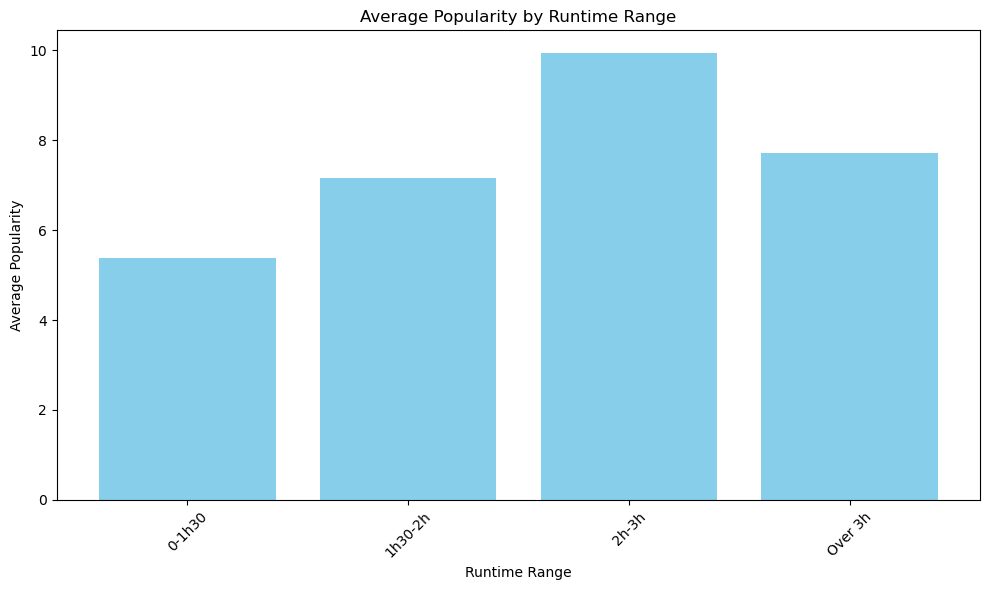

In [5]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(hypothesis_1_df['runtime_range'], hypothesis_1_df['avg_popularity'], color='skyblue')
plt.xlabel('Runtime Range')
plt.ylabel('Average Popularity')
plt.title('Average Popularity by Runtime Range')
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

In [13]:
# Define your queries
query3 = """
SELECT 
    genres AS genre,
    ROUND(AVG(revenue), 2) AS average_revenue
FROM 
    movies_schema.movies_metadata
WHERE 
    genres IS NOT NULL AND genres <> '' AND revenue IS NOT NULL
GROUP BY 
    genres
HAVING 
    AVG(revenue) IS NOT NULL
    AND AVG(revenue) > 0 -- Filter out genres with average revenue of 0
ORDER BY 
    average_revenue DESC;
"""

# Create a connection
connection = engine.connect()

# Execute the query and read the result into a DataFrame
hypothesis_2_df = pd.read_sql_query(query3, connection)



# Close the database connection
connection.close()

# Print the results
print("Query 3 Results:")
print(hypothesis_2_df.head())

Query 3 Results:
             genre  average_revenue
0        Adventure     1.504441e+08
1        Animation     1.404673e+08
2  Science Fiction     1.351056e+08
3           Family     1.345392e+08
4           Action     8.742986e+07


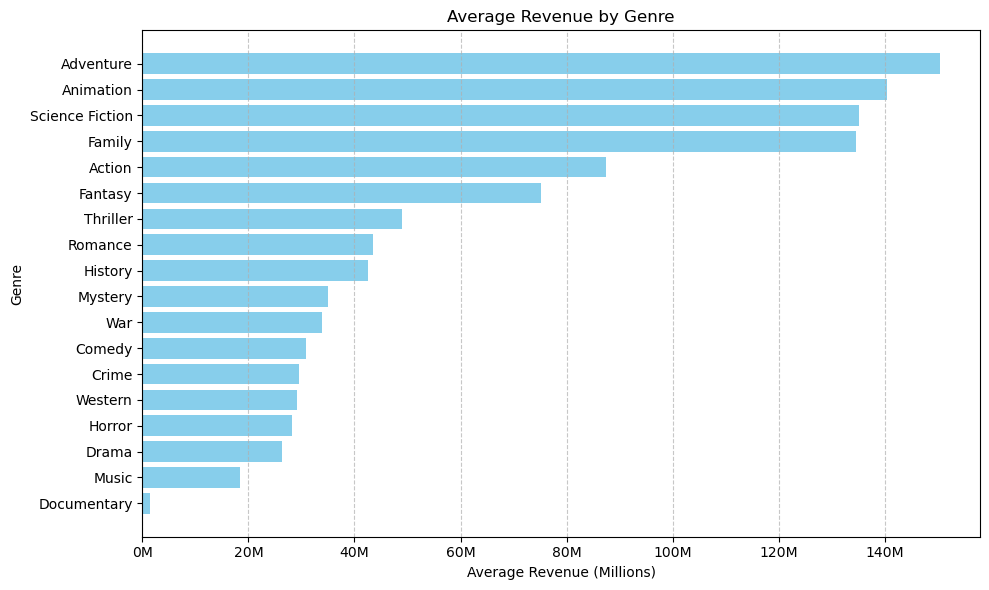

In [14]:
from matplotlib.ticker import FuncFormatter

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(hypothesis_2_df['genre'], hypothesis_2_df['average_revenue'], color='skyblue')

# Function to format x-axis labels to display millions in a concise format (e.g., 20M instead of 20000000M)
def millions_formatter(x, pos):
    # Divide x by 1,000,000 to convert it back to millions for display
    return f'{int(x / 1000000)}M'

# Set the formatter for x-axis labels
formatter = FuncFormatter(millions_formatter)
plt.gca().xaxis.set_major_formatter(formatter)

plt.xlabel('Average Revenue (Millions)')
plt.ylabel('Genre')
plt.title('Average Revenue by Genre')
plt.gca().invert_yaxis()  # Invert y-axis to have highest revenue at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Display plot
plt.show()

In [8]:
query4 = """
SELECT 
    m.title,
    m.budget,
    ROUND(AVG(r.rating), 1) AS average_rating
FROM 
    movies_schema.movies_metadata m
JOIN 
    (SELECT DISTINCT movieId, userId, rating FROM movies_schema.ratings_small) r ON m.id = r.movieId
WHERE 
    m.budget IS NOT NULL
GROUP BY
    m.title,
    m.budget
ORDER BY 
    m.budget DESC
LIMIT 15;
"""

In [15]:
# Create a connection
connection = engine.connect()

# Execute the query and read the result into a DataFrame
hypothesis_3_df = pd.read_sql_query(query4, connection)

# Close the database connection
connection.close()

# Print the results
print("Query 3 Results:")
print(hypothesis_3_df.head())

Query 3 Results:
                                         title     budget  average_rating
0  Pirates of the Caribbean: On Stranger Tides  380000000             4.0
1     Pirates of the Caribbean: At World's End  300000000             4.0
2                                 Spider-Man 3  258000000             5.0
3       Harry Potter and the Half-Blood Prince  250000000             4.0
4     The Chronicles of Narnia: Prince Caspian  225000000             3.7


In [18]:
import plotly.express as px

# Plotting with Plotly
fig = px.bar(hypothesis_3_df, 
             x='average_rating',  # Inverted: average rating on x-axis
             y='title',           # Movies titles on y-axis
             text='budget',       # Show budget as text annotations
             title='Top 15 Movies with Highest Budget and Their Average Ratings',
             labels={'average_rating': 'Average Rating', 'title': 'Movie Title', 'budget': 'Budget (in USD)'},
             height=600,
             orientation='h')     # Horizontal bar plot

# Format x-axis as one decimal place for average rating
fig.update_layout(xaxis_tickformat='.1f')

# Add annotations for budget on each bar
fig.update_traces(texttemplate='$%{text:.2s}', textposition='outside')

# Show plot
fig.show()